# ICML Paper Plots (without Lesion Test)

In [56]:
import sys
sys.path.append('..')

import pickle

import numpy as np
from tqdm import trange
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from src.experiment_tagging import get_model_path
from src.visualization import run_spectral_cluster
from src.random_init import compute_ncut_random_init_mlp
from src.utils import cohen_d, cohen_d_stats

In [57]:
N_MODELS = 10
N_SHUFFLES = 320

## 1. Primary Models (`ncut` vs. `acc`)

In [58]:
def training_text(is_pruned, is_dropout):
    pruned_text = ('w/' if is_pruned else 'w/o')
    dropout_text = ('w/' if is_dropout else 'w/o')
    return f'{pruned_text} pruning ; {dropout_text} dropout'

In [59]:
"""
clustering_stability_statistics = pd.concat([pd.read_csv('../results/mlp-clustering-stability-statistics.csv').assign(is_pruned=True),
                                             pd.read_csv('../results/mlp-clustering-stability-statistics-unpruned.csv').assign(is_pruned=False)
                                            ], sort=False)
"""

clustering_stability_statistics = pd.concat([pd.read_csv('../results/mlp-clustering-stability-all-samples.csv').assign(is_pruned=True),
                                             pd.read_csv('../results/mlp-clustering-stability-all-samples-unpruned.csv').assign(is_pruned=False)
                                            ], sort=False)


                   
clustering_stability_statistics['is_dropout'] = clustering_stability_statistics['model'].str.contains('DROPOUT')
clustering_stability_statistics['Dataset'] = clustering_stability_statistics['model'].str.split('+').str[0]

clustering_stability_statistics['Training'] = clustering_stability_statistics.apply(lambda r: 
                                                                                    training_text(r['is_pruned'], r['is_dropout']),
                                                                                    axis=1)

PRIMARY_DATASETS = ['MNIST', 'FASHION', 'CIFAR10']

primary_models_df = clustering_stability_statistics[clustering_stability_statistics['Dataset'].isin(PRIMARY_DATASETS)]

primary_models_df = primary_models_df[['model', 'Dataset', 'Training',
                                                     'is_pruned', 'is_dropout', 'ncut', 'test_acc']]
primary_models_df = primary_models_df.drop('model', axis=1)

In [60]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

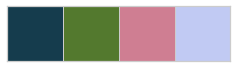

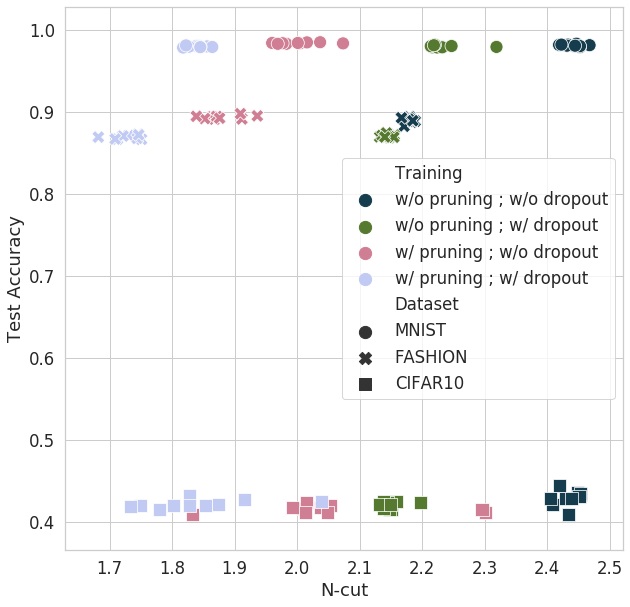

In [61]:
# reorder colors to make sure that red-green and blue-orange do not overlap
# refactor that with color names!
#pruning_dropout_palette = sns.color_palette()
#pruning_dropout_palette = pruning_dropout_palette[3], pruning_dropout_palette[2], pruning_dropout_palette[0], pruning_dropout_palette[1]
pruning_dropout_palette = sns.color_palette('cubehelix', 4)

sns.palplot(pruning_dropout_palette)


f, ax = plt.subplots(1, figsize=(10, 10))
g = sns.scatterplot(x='ncut',
                y='test_acc',
                style='Dataset',
                hue='Training',
               hue_order=['w/o pruning ; w/o dropout',
                           'w/o pruning ; w/ dropout',
                             'w/ pruning ; w/o dropout',
                             'w/ pruning ; w/ dropout'],
             style_order=['MNIST',
                           'FASHION',
                             'CIFAR10'],
                s=170,
                palette=pruning_dropout_palette,
                data=primary_models_df, ax=ax)

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])

#ax.legend(loc='upper left', bbox_to_anchor= (0.0, -0.2), ncol=2, 
#            borderaxespad=0, frameon=False)

for lh in g.legend_.legendHandles: 
    lh._sizes = [150] 

# plt.title('Primary Models: N-cut and Test Accuracy')
plt.xlabel('N-cut')
plt.ylabel('Test Accuracy')
plt.savefig('../plots/scatter-primary-models.png', dpi=300)

In [62]:
# break in the middle
# https://matplotlib.org/examples/pylab_examples/broken_axis.html

## 2. N-cut Distribution of Shuffled Weights

### FASHION Last (paper)

In [63]:
SHUFFLE_METHODS = ['layer',
                   'layer_nonzero',
                   #'layer_nonzero_distribution',
                   #'layer_all_distribution'
                  ]

def build_model_path_for_shuffeling(model, is_pruned, is_dropout, index='last'):
    prunability = 'pruned'
    if not is_pruned:
        prunability = 'un' + prunability

    dataset = model.lower()
    tag = model
    if is_dropout:
        tag += '+DROPOUT'

    if index == 'last':
        model_path = get_model_path(tag, filter_='last', model_base_path='/scratch/shlomi/models/')
    else:
        model_path = get_model_path(tag, filter_='all', model_base_path='/scratch/shlomi/models/')[index]

    return model_path / f'{dataset}-mlp-{prunability}-weights.pckl'


def generate_shuffled_ncuts(model_path):


    return {shuffle_method: run_spectral_cluster(model_path,
                                   n_samples=N_SHUFFLES,
                                   with_shuffled_ncuts=True,
                                   shuffle_method=shuffle_method)[1]
               for shuffle_method in SHUFFLE_METHODS}


def generate_all_shuffled_ncuts(filter_='last'):
    results = {}

    for model in tqdm(['CIFAR10']): #['MNIST', 'FASHION', 
        results[model] = {}
        for is_pruned in tqdm([False, True]):
            results[model][is_pruned] = {}
            for is_dropout in tqdm([False, True]):
                if filter_ == 'last':
                    model_path_for_shuffling = build_model_path_for_shuffeling(model, is_pruned, is_dropout,
                                                                               index='last')
                    results[model][is_pruned][is_dropout] = generate_shuffled_ncuts(model_path_for_shuffling)
                elif filter_ == 'all':
                    results[model][is_pruned][is_dropout] = []
                    for i in range(1, N_MODELS + 1):#11):
                        model_path_for_shuffling = build_model_path_for_shuffeling(model, is_pruned, is_dropout,
                                                                              index=-i)
                        results[model][is_pruned][is_dropout].append(generate_shuffled_ncuts(model_path_for_shuffling))
                        
    return results

In [64]:
if False:

    fashion_shuffled_last_results = generate_all_shuffled_ncuts(filter_='last')
                
    with open ('../results/mlp-shuffle-methods.pickle', 'wb') as f:
        pickle.dump(fashion_shuffled_last_results, f)

else:
    
    with open ('../results/mlp-shuffle-methods.pickle', 'rb') as f:
        fashion_shuffled_last_results = pickle.load(f)

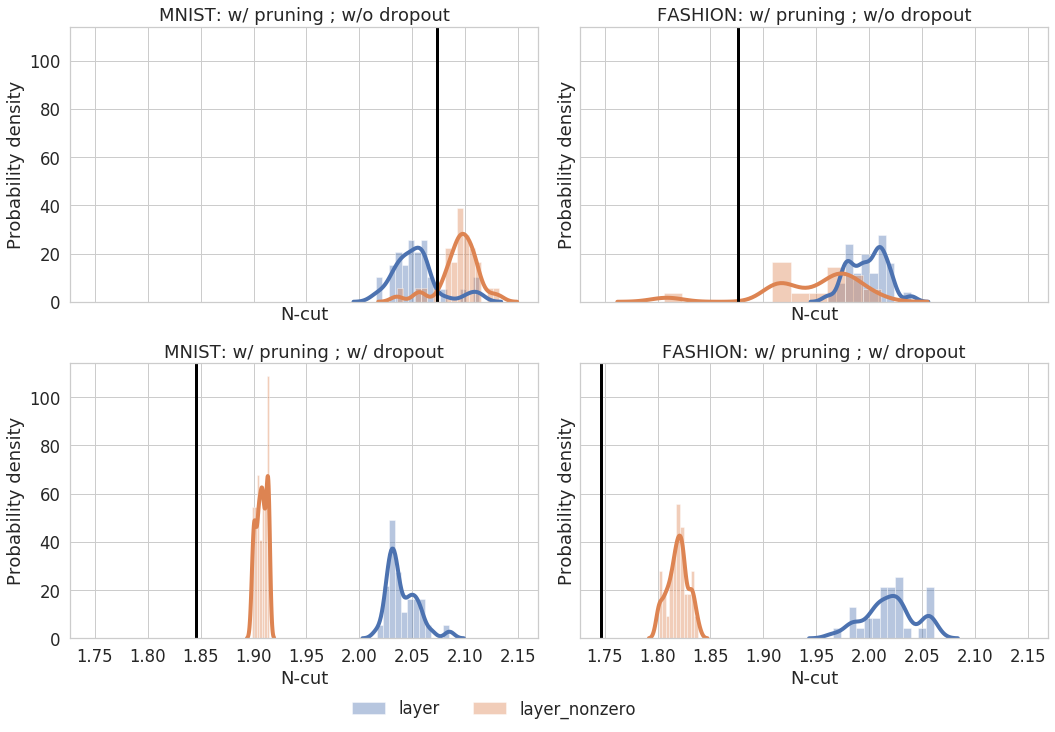

In [65]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

is_pruned = True
for is_dropout, axes_row in zip([False, True], axes):
    for model, ax in zip(['MNIST', 'FASHION'], axes_row):
        for shuffle_method in ['layer', 'layer_nonzero']:
            sns.distplot(fashion_shuffled_last_results[model][is_pruned][is_dropout][shuffle_method]['shuffled_ncuts'],
                         label=shuffle_method, hist=True, kde=True, kde_kws=dict(linewidth=4), norm_hist=True,
                        ax=ax,
                        )

            ax.axvline(fashion_shuffled_last_results[model][is_pruned][is_dropout]['layer']['ncut'],
                    color='black', linewidth=3)
        ax.title.set_text(f'{model}: ' + training_text(is_pruned, is_dropout))
        
        ax.set_xlabel('N-cut')
        ax.set_ylabel('Probability density')
        
f.tight_layout()

plt.legend(loc='upper left', bbox_to_anchor= (-0.5, -0.2), ncol=2, 
           borderaxespad=0, frameon=False)
#f.suptitle('N-cut Distribution from Monte Carlo')

plt.savefig('../plots/ncut-dist-monte-carlo.png', dpi=300, bbox_inches='tight')

### All Primary (supplemental)

In [66]:
if False:

    all_instances_shuffled_results = generate_all_shuffled_ncuts(filter_= 'all')
                
    with open ('../results/mlp-shuffle-methods-all-instances.pickle', 'wb') as f:
        pickle.dump(all_instances_shuffled_results, f)

else:
    
    with open ('../results/mlp-shuffle-methods-all-instances.pickle', 'rb') as f:
        all_instances_shuffled_results = pickle.load(f)


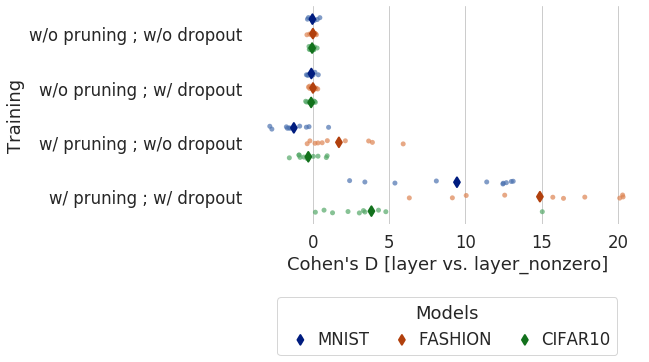

In [67]:
# todo: refactor: make all of that as an iterator


def check_if_sig(percentile, n_samples):
    return  np.isclose(percentile,
                       1 / (n_samples + 1))


all_instances_shuffled_records = []
for model in ['MNIST', 'FASHION', 'CIFAR10']:
    for is_pruned in [False, True]:
        for is_dropout in [False, True]:
            for index in range(N_MODELS):
                
                result = all_instances_shuffled_results[model][is_pruned][is_dropout][index]
                
                assert result['layer']['ncut'] == result['layer_nonzero']['ncut']
                assert result['layer']['n_samples'] == result['layer_nonzero']['n_samples']
                assert result['layer']['train_acc'] == result['layer_nonzero']['train_acc']
                assert result['layer']['train_loss'] == result['layer_nonzero']['train_loss']
                assert result['layer']['test_acc'] == result['layer_nonzero']['test_acc']
                assert result['layer']['test_loss'] == result['layer_nonzero']['test_loss']


                all_instances_shuffled_records.append({'model': model,
                                                       'is_pruned': is_pruned,
                                                       'is_dropout': is_dropout,
                                                       'instance': index,
                                                       
                                                       'ncut': result['layer']['ncut'],
                                                       'n_samples': result['layer']['n_samples'],

                                                       'layer-mean': result['layer']['mean'],
                                                       'layer-stdev': result['layer']['stdev'],
                                                       'layer-min': result['layer']['shuffled_ncuts'].min(),
                                                       'layer-max': result['layer']['shuffled_ncuts'].max(),
                                                       'layer-percentile': result['layer']['percentile'],
                                                       'layer-is_sig': check_if_sig(result['layer']['percentile'],
                                                                                     result['layer']['n_samples']),

                                                       'layer_nonzero-mean': result['layer_nonzero']['mean'],
                                                       'layer_nonzero-stdev': result['layer_nonzero']['stdev'],
                                                       'layer_nonzero-min': result['layer_nonzero']['shuffled_ncuts'].min(),
                                                       'layer_nonzero-max': result['layer_nonzero']['shuffled_ncuts'].max(),
                                                       'layer_nonzero-percentile': result['layer_nonzero']['percentile'],
                                                       'layer_nonzero-is_sig': check_if_sig(result['layer_nonzero']['percentile'],
                                                                                             result['layer_nonzero']['n_samples']),

                                                       'cohen_d': cohen_d(result['layer']['shuffled_ncuts'], result['layer_nonzero']['shuffled_ncuts'])
                                                      })
                
all_instances_shuffled_df = pd.DataFrame(all_instances_shuffled_records)

all_instances_shuffled_df['Training'] = all_instances_shuffled_df.apply(lambda r: training_text(r['is_pruned'],
                                                                                                r['is_dropout']), axis=1)
# Initialize the figure
f, ax = plt.subplots(1, figsize=(7, 4))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="cohen_d", y="Training", hue="model",
              data=all_instances_shuffled_df, dodge=True, alpha=.70, zorder=1)


# Show the conditional means
sns.pointplot(x="cohen_d", y="Training", hue="model",
              data=all_instances_shuffled_df, dodge=.532, join=False, palette="dark",
              markers="d", scale=1, ci=None)

plt.xlabel("Cohen's D [layer vs. layer_nonzero]")
# Improve the legend 
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[3:], labels[3:], title="Models",
          handletextpad=0, columnspacing=1,
          loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=3, frameon=True)


plt.savefig('../plots/mlp-ncut-cohens-d.png', dpi=300, bbox_inches='tight')

In [68]:
all_instances_shuffled_df.to_csv('../results/mlp-ncut-cohens-d.csv')

all_instances_shuffled_df.head()

,cohen_d,instance,is_dropout,is_pruned,layer-is_sig,layer-max,layer-mean,layer-min,layer-percentile,layer-stdev,layer_nonzero-is_sig,layer_nonzero-max,layer_nonzero-mean,layer_nonzero-min,layer_nonzero-percentile,layer_nonzero-stdev,model,n_samples,ncut,Training
0,-0.086594,0,False,False,False,2.587290,2.455674,2.392710,0.065421,0.037763,False,2.584285,2.459188,2.405199,0.065421,0.043106,MNIST,320,2.422764,w/o pruning ; w/o dropout
1,0.468321,1,False,False,True,2.592518,2.474398,2.427974,0.003115,0.050393,True,2.526267,2.456442,2.424875,0.003115,0.019789,MNIST,320,2.419015,w/o pruning ; w/o dropout
2,-0.279566,2,False,False,False,2.588794,2.464600,2.426509,0.345794,0.045183,False,2.594879,2.478863,2.419064,0.345794,0.056108,MNIST,320,2.444622,w/o pruning ; w/o dropout
3,-0.104080,3,False,False,False,2.588916,2.473815,2.327765,0.439252,0.069484,False,2.582199,2.480864,2.356267,0.501558,0.065714,MNIST,320,2.452505,w/o pruning ; w/o dropout
4,0.296669,4,False,False,False,2.597346,2.466875,2.349642,0.190031,0.057773,False,2.568277,2.452353,2.410149,0.190031,0.037939,MNIST,320,2.431656,w/o pruning ; w/o dropout


### Distribution for all model instance of MNIST (pruning, dropout) (supplemental)

In [54]:
results_by_training = {}
flatten_shuffled_results = []
ncut_results = []

for is_pruned in [False, True]:
    for is_dropout in [False, True]:
        condition = (is_pruned, is_dropout)
        results_by_training[condition] = {'ncut': []}
        shuffled_ncut_records = []
        
        for index in range(N_MODELS):

            
            mnist_results = (all_instances_shuffled_results
                             ['MNIST']
                             [is_pruned]
                             [is_dropout]
                             [index])
            
            results_by_training[condition]['ncut'].append(mnist_results['layer']['ncut'])
            
            for shuffle_method in SHUFFLE_METHODS:
                shuffled_ncut_records.extend([{'Instance': index,
                   'N-cut': snc,
                    'Shuffle method': shuffle_method, 
                   } for snc in mnist_results[shuffle_method]['shuffled_ncuts']])

                
        results_by_training[condition]['df'] = pd.DataFrame(shuffled_ncut_records)

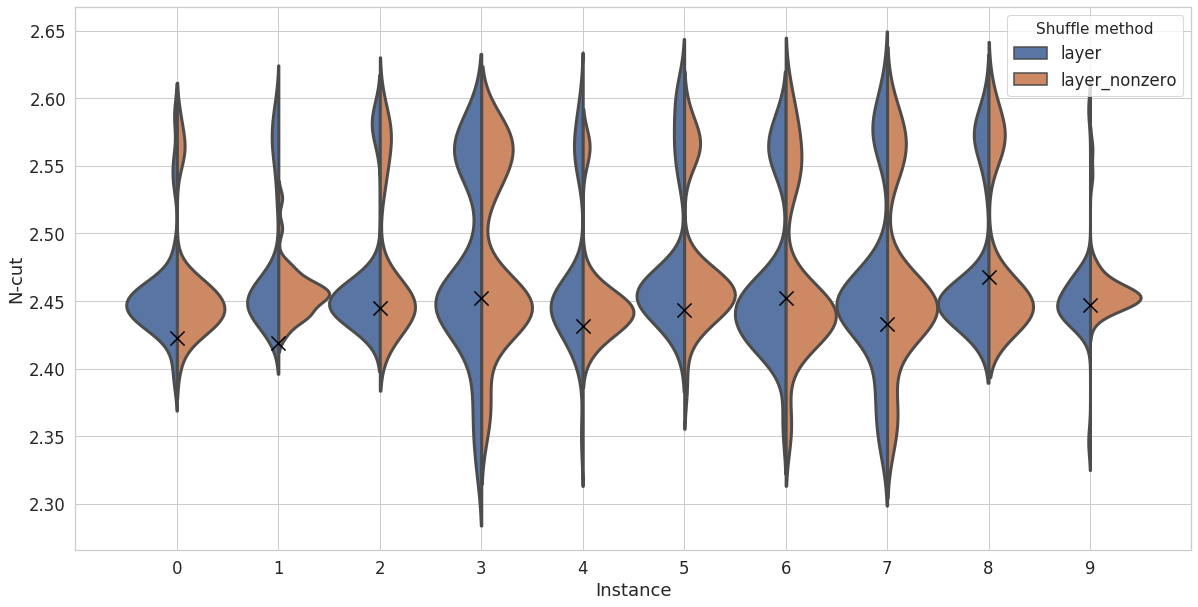

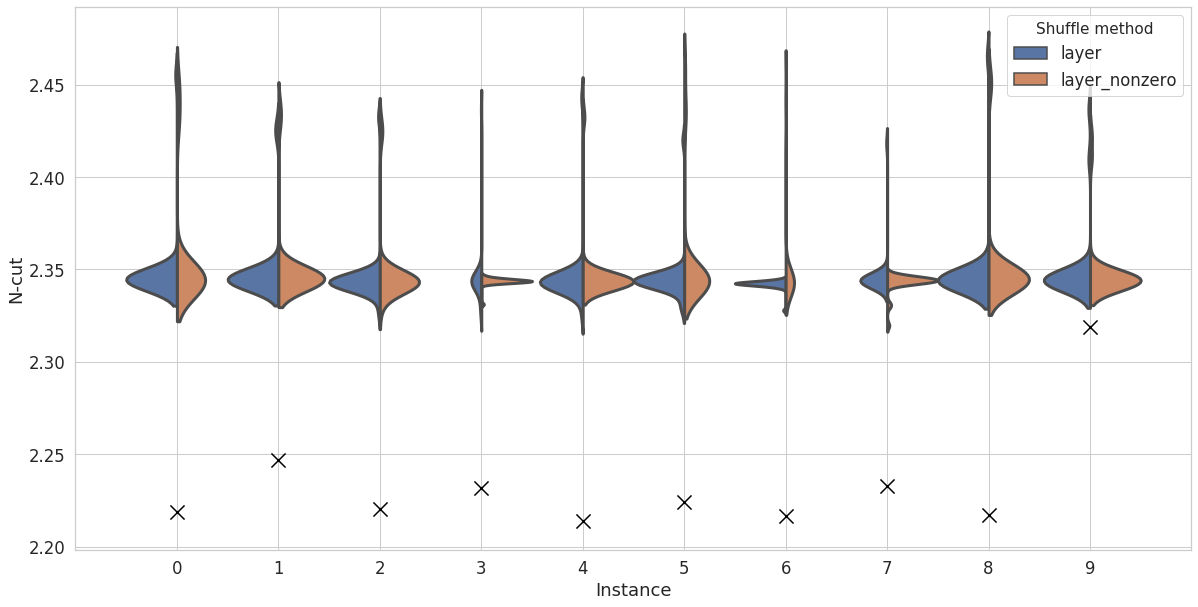

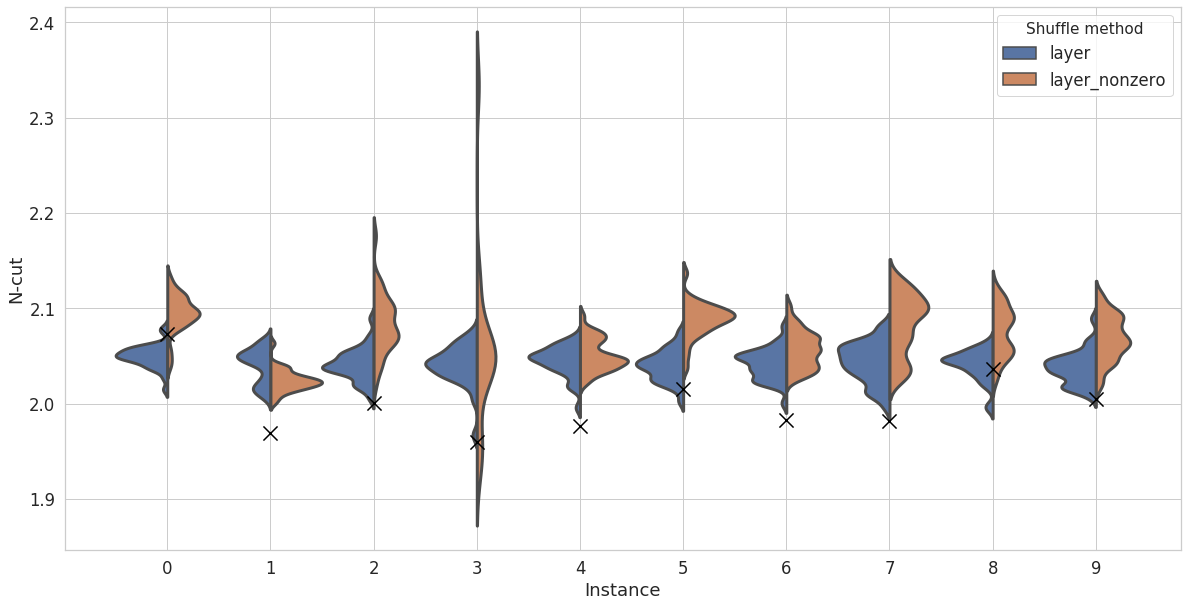

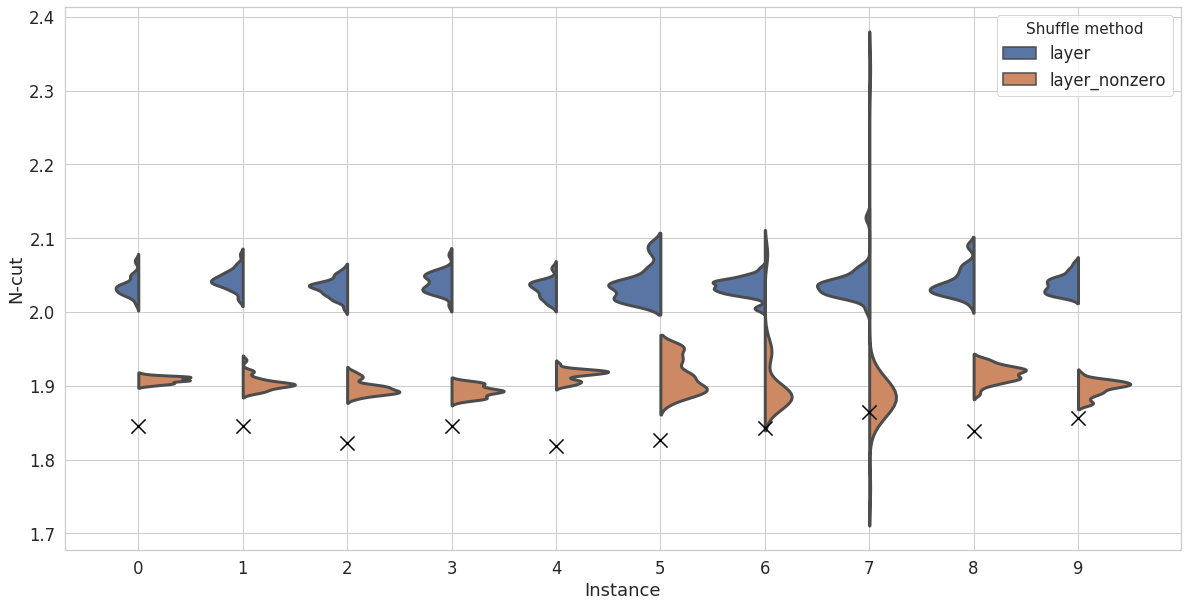

In [55]:
for is_pruned in [False, True]:
    for is_dropout in [False, True]: 
        condition = (is_pruned, is_dropout)

        title = (training_text(is_pruned, is_dropout)
                 .replace('/','-')
                 .replace(' ', '_')
                 .replace(';', ''))
        
        f, ax = plt.subplots(1, figsize=(20, 10))

        sns.violinplot(y='N-cut', x='Instance',
                       hue='Shuffle method',
                       split=True, inner=None,
                       width=1, linewidth=3,
                       data=results_by_training[condition]['df'])
        ax.grid(True)
        #plt.xlabel('Model Instance')
        #plt.ylabel('Ncut')
        # plt.title(title)
        plt.scatter(range(N_MODELS), results_by_training[condition]['ncut'], color='black', marker='x', s=200)
        
        plt.savefig(f'../plots/mlp-mnist-shuffled-ncuts-violin-{title}.png', dpi=300)

## Ncut Distribution of Random Initialized Networks

In [23]:
from src.random_init import compute_ncut_random_init_mlp

random_init_ncuts = [compute_ncut_random_init_mlp() for _ in trange(200)]

  0%|          | 0/200 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


WARNING - tensorflow - From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
100%|██████████| 200/200 [15:43<00:00,  4.72s/it]


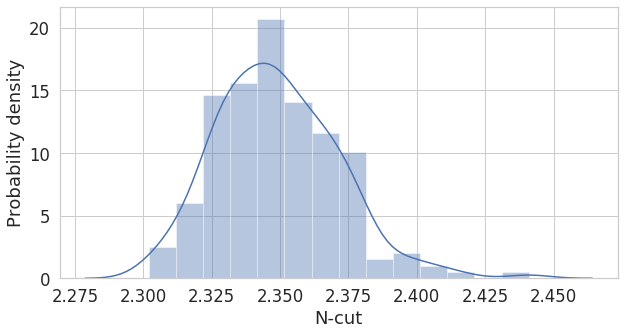

In [58]:
f, ax = plt.subplots(1, figsize=(10, 5))
sns.distplot(random_init_ncuts)
# plt.title('N-cut Distribution of Random-Initialized MLPs without any Training (200 samples)');

# plt.axvline(results['FASHION'][False][False]['layer']['ncut'],
#                    color='black', linewidth=3,
#            label='FASHION (w/o pruning ; w/o dropout)')

# plt.axvline(results['MNIST'][False][False]['layer']['ncut'],
#                    color='black', linewidth=3,
#           label='MNIST (w/o pruning ; w/o dropout)', linestyle='--')

# plt.legend(loc='upper left', bbox_to_anchor= (0.0, -0.2), ncol=2, 
#            borderaxespad=0, frameon=False)

plt.xlabel('N-cut')
plt.ylabel('Probability density')

plt.savefig('../plots/ncut-dist-random-init.png', dpi=300)

# Dump

## P-value Histogram

In [51]:
clustering_stability_statistics

,Unnamed: 0,ave_in_out,mean,n_samples,ncut,percentile,stdev,test_acc,test_loss,train_acc,train_loss,z_score,model,is_sig,is_pruned,is_dropout,Dataset,Training
0,0,0.497503,2.034442,320.0,2.005006,0.096573,0.022441,0.9835,0.095332,1.000000,0.000048,-1.311722,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout
1,1,0.481929,2.035213,320.0,2.036808,0.439252,0.014743,0.9847,0.090697,1.000000,0.000056,0.108146,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout
2,2,0.509254,2.042848,320.0,1.981663,0.003115,0.012102,0.9830,0.099833,1.000000,0.000059,-5.055921,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
3,3,0.508688,2.041044,320.0,1.982774,0.003115,0.020362,0.9828,0.099546,1.000000,0.000062,-2.861703,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
4,4,0.492170,2.045410,320.0,2.015783,0.003115,0.015201,0.9845,0.097756,1.000000,0.000081,-1.949092,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
5,5,0.511748,2.049580,320.0,1.976777,0.003115,0.017383,0.9835,0.095626,1.000000,0.000048,-4.188122,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
6,6,0.520357,2.039954,320.0,1.960098,0.003115,0.013662,0.9838,0.087238,1.000000,0.000056,-5.845216,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
7,7,0.499423,2.044081,320.0,2.001155,0.003115,0.016928,0.9838,0.100444,1.000000,0.000061,-2.535831,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
8,8,0.515698,2.041622,320.0,1.969089,0.003115,0.019876,0.9828,0.093142,1.000000,0.000047,-3.649229,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
9,9,0.464563,2.050418,320.0,2.073477,0.937695,0.019004,0.9833,0.102283,1.000000,0.000049,1.213369,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout


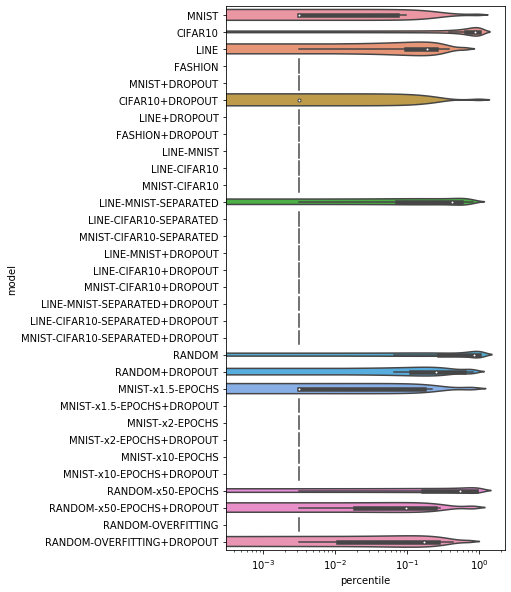

In [52]:
f, ax = plt.subplots(1, figsize=(5, 10))
g = sns.violinplot(x='percentile', y='model',
                   data=clustering_stability_statistics)

g.set_xscale('log')

CIFAR10


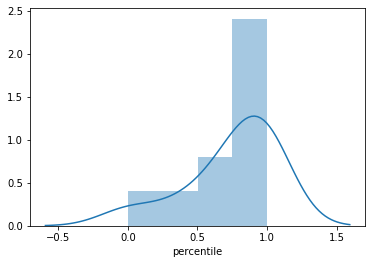

In [79]:
#f, ax = plt.subplots(1, figsize=(5, 10))
for d in ['CIFAR10']:
    df = clustering_stability_statistics[(clustering_stability_statistics['Dataset'] == d)
                                         & clustering_stability_statistics['is_pruned']
                                         & (~clustering_stability_statistics['is_dropout'])]
    print(d)
    sns.distplot(df['percentile'])
    

In [80]:
df

,Unnamed: 0,ave_in_out,mean,n_samples,ncut,percentile,stdev,test_acc,test_loss,train_acc,train_loss,z_score,model,is_sig,is_pruned,is_dropout,Dataset,Training
10,10,0.495938,2.004655,320.0,2.008157,0.626168,0.018647,0.4164,2.009407,0.64702,0.982019,0.187770,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
11,11,0.473770,2.003878,320.0,2.053872,1.000000,0.013368,0.4196,2.009614,0.65526,0.968012,3.739722,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
12,12,0.591393,1.996205,320.0,1.832521,0.003115,0.015846,0.4085,2.026656,0.64580,0.993128,-10.329533,CIFAR10,True,True,False,CIFAR10,w/ pruning ; w/o dropout
13,13,0.369314,1.993271,320.0,2.300665,1.000000,0.015930,0.4107,2.004410,0.64558,0.992089,19.296861,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
14,14,0.492378,2.008232,320.0,2.015361,0.719626,0.015461,0.4239,1.981631,0.65444,0.964225,0.461050,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
15,15,0.493085,1.995109,320.0,2.013927,0.813084,0.017096,0.4111,2.053139,0.65218,0.973041,1.100748,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
16,16,0.503668,2.000106,320.0,1.992691,0.376947,0.016595,0.4178,1.984371,0.64454,0.994267,-0.446817,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
17,17,0.481637,2.007039,320.0,2.037413,0.968847,0.014711,0.4177,1.981042,0.65184,0.974107,2.064680,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
18,18,0.371163,1.996229,320.0,2.295781,1.000000,0.016127,0.4150,2.007964,0.64328,0.998221,18.574486,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout
19,19,0.476091,2.004057,320.0,2.048989,0.937695,0.017723,0.4116,2.029548,0.66094,0.956555,2.535280,CIFAR10,False,True,False,CIFAR10,w/ pruning ; w/o dropout


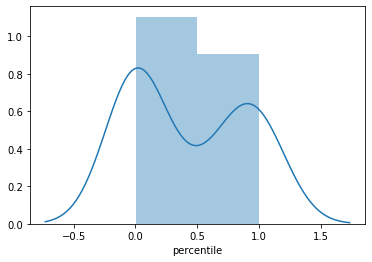

In [68]:
sns.distplot(df['percentile'])

In [42]:
clustering_stability_statistics

,Unnamed: 0,ave_in_out,mean,n_samples,ncut,percentile,stdev,test_acc,test_loss,train_acc,train_loss,z_score,model,is_sig,is_pruned,is_dropout,Dataset,Training
0,0,0.497503,2.034442,320.0,2.005006,0.096573,0.022441,0.9835,0.095332,1.000000,0.000048,-1.311722,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout
1,1,0.481929,2.035213,320.0,2.036808,0.439252,0.014743,0.9847,0.090697,1.000000,0.000056,0.108146,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout
2,2,0.509254,2.042848,320.0,1.981663,0.003115,0.012102,0.9830,0.099833,1.000000,0.000059,-5.055921,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
3,3,0.508688,2.041044,320.0,1.982774,0.003115,0.020362,0.9828,0.099546,1.000000,0.000062,-2.861703,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
4,4,0.492170,2.045410,320.0,2.015783,0.003115,0.015201,0.9845,0.097756,1.000000,0.000081,-1.949092,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
5,5,0.511748,2.049580,320.0,1.976777,0.003115,0.017383,0.9835,0.095626,1.000000,0.000048,-4.188122,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
6,6,0.520357,2.039954,320.0,1.960098,0.003115,0.013662,0.9838,0.087238,1.000000,0.000056,-5.845216,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
7,7,0.499423,2.044081,320.0,2.001155,0.003115,0.016928,0.9838,0.100444,1.000000,0.000061,-2.535831,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
8,8,0.515698,2.041622,320.0,1.969089,0.003115,0.019876,0.9828,0.093142,1.000000,0.000047,-3.649229,MNIST,True,True,False,MNIST,w/ pruning ; w/o dropout
9,9,0.464563,2.050418,320.0,2.073477,0.937695,0.019004,0.9833,0.102283,1.000000,0.000049,1.213369,MNIST,False,True,False,MNIST,w/ pruning ; w/o dropout
